In [86]:
Attirbution towards https://github.com/JamesMcGuigan/dataset-kepler for the data cleaning and FastAI model used. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Python imports and settings
import numpy  as np
import pandas as pd
import seaborn as sns
import scipy.stats
import re
from pydash import py_ as _
from sklearn.preprocessing import OneHotEncoder

from src.dataset_koi import koi, koi_columns, koi_column_types
from src.utilities import onehot_encode_comments

# https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_rows', 8)  # 8 is required for .describe()

%load_ext autoreload
%autoreload 2

In [87]:
dataset        = koi['all']; 
onehot_dataset = (
    pd.concat([ 
        # koi['id'],         
        koi['archive'], 
        koi['disposition'], 
        koi['transit'], 
        koi['TCE'], 
        koi['stellar'], 
        koi['KIC'], 
        koi['pixels'],         

        # pd.get_dummies(dataset[['koi_disposition']]),
        # pd.get_dummies(dataset[['koi_fittype']]),
        # pd.get_dummies(dataset[['koi_tce_delivname']]),
        onehot_encode_comments(dataset, 'koi_comment', '---', without=['NO_COMMENT']).astype('int32'),
    ], axis=1)
)
onehot_dataset

,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_comment,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_fittype,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff1,koi_ldm_coeff2,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_fwm_stat_sig,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,koi_comment_ALL_TRANS_CHASES,koi_comment_ALT_ROBO_ODD_EVEN_TEST_FAIL,koi_comment_ALT_SEC_SAME_DEPTH_AS_PRI_COULD_BE_TWICE_TRUE_PERIOD,koi_comment_ALT_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_ALT_SIG_PRI_MINUS_SIG_TER_TOO_LOW,koi_comment_ALT_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_CENTROID_SIGNIF_UNCERTAIN,koi_comment_CENT_CROWDED,koi_comment_CENT_FEW_DIFFS,koi_comment_CENT_FEW_MEAS,koi_comment_CENT_KIC_POS,koi_comment_CENT_NOFITS,koi_comment_CENT_RESOLVED_OFFSET,koi_comment_CENT_SATURATED,koi_comment_CENT_UNCERTAIN,koi_comment_CENT_UNRESOLVED_OFFSET,koi_comment_CLEAR_APO,koi_comment_CROWDED_DIFF,koi_comment_DEEP_V_SHAPED,koi_comment_DEPTH_ODDEVEN_ALT,koi_comment_DEPTH_ODDEVEN_DV,koi_comment_DV_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_DV_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_EPHEM_MATCH,koi_comment_EYEBALL,koi_comment_FIT_FAILED,koi_comment_HALO_GHOST,koi_comment_HAS_SEC_TCE,koi_comment_INCONSISTENT_TRANS,koi_comment_INDIV_TRANS_CHASES,koi_comment_INDIV_TRANS_CHASES_MARSHALL,koi_comment_INDIV_TRANS_CHASES_MARSHALL_SKYE,koi_comment_INDIV_TRANS_CHASES_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_CHASES_SKYE,koi_comment_INDIV_TRANS_MARSHALL,koi_comment_INDIV_TRANS_MARSHALL_SKYE,koi_comment_INDIV_TRANS_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_RUBBLE,koi_comment_INDIV_TRANS_RUBBLE_MARSHALL_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_SKYE,koi_comment_INDIV_TRANS_SKYE_ZUMA,koi_comment_INDIV_TRANS_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_ZUMA,koi_comment_INVERT_DIFF,koi_comment_IS_SEC_TCE,koi_comment_KIC_OFFSET,koi_comment_LPP_ALT,koi_comment_LPP_ALT_TOO_HIGH,koi_comment_LPP_DV,koi_comment_LPP_DV_TOO_HIGH,koi_comment_MARSHALL_FAIL,koi_comment_MOD_NONUNIQ_ALT,koi_comment_MOD_NONUNIQ_DV,koi_comment_MOD_ODDEVEN_ALT,koi_comment_MOD_ODDEVEN_DV,koi_comment_MOD_POS_ALT,koi_comment_MOD_POS_DV,koi_comment_MOD_SEC_ALT,koi_comment_MOD_SEC_DV,koi_comment_MOD_TER_ALT,koi_comment_MOD_TER_DV,koi_comment_OTHER_TCE_AT_SAME_PERIOD_DIFF_EPOCH,koi_comment_PARENT_IS_002305372-pri,koi_comment_PARENT_IS_002449084-pri,koi_comment_PARENT_IS_003352751-pri,koi_comment_PARENT_IS_003858884-01,koi_comment_PARENT_IS_004482641-01,koi_comment_PARENT_IS_005024292-01,koi_comment_PARENT_IS_005036538-01,koi_comment_PARENT_IS_005343976-pri,koi_comment_PARENT_IS_005471619-pri,koi_comment_PARENT_IS_005513861-pri,koi_comment_PARENT_IS_006367628-pri,koi_comment_PARENT_IS_007258889-pri,koi_comment_PARENT_IS_007598128-pri,koi_comment_PARENT_IS_008265951-pri,koi_comment_PARENT_IS_008380743-pri,koi_comment_PARENT_IS_009541127-pri,koi_comment_PARENT_IS_009777062-01,koi_comment_PARENT_IS_010485137-pri,koi_comment_PARENT_IS_010858720-pri,koi_comment_PARENT_IS_012004679-pri,koi_comment_PARENT_IS_3597.01,koi_comment_PARENT_IS_3895.01,koi_comment_PARENT_IS_4673.01,koi_comment_PARENT_IS_489.01,koi_comment_PARENT_IS_5335.01,koi_comment_PARENT_IS_970.01,koi_comment_PARENT_IS_FL-Lyr-pri,koi_comment_PARENT_IS_RR-Lyr-pri,koi_comment_PARENT_IS_UZ-Lyr-pri,koi_comment_PARENT_IS_V2277-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-sec,koi_comment_PARENT_IS_V850-Cyg-pri,koi_comment_PERIOD_ALIAS_ALT,koi_comment_PERIOD_ALIAS_DV,koi_comme

In [88]:
df = (
    onehot_dataset
        .drop(columns=[
            'kepid','kepoi_star','kepoi_name','kepler_name','koi_pdisposition','koi_comment','koi_quarters','koi_sparprov',
            'koi_kepmag', 'koi_fittype', 'koi_tce_delivname',  # unencoded categorical columns
        ], errors='ignore')        
        .reset_index()    
        .drop(columns=['kepoi_name'])        
)
df

,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff1,koi_ldm_coeff2,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,ra,dec,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_fwm_stat_sig,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,koi_comment_ALL_TRANS_CHASES,koi_comment_ALT_ROBO_ODD_EVEN_TEST_FAIL,koi_comment_ALT_SEC_SAME_DEPTH_AS_PRI_COULD_BE_TWICE_TRUE_PERIOD,koi_comment_ALT_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_ALT_SIG_PRI_MINUS_SIG_TER_TOO_LOW,koi_comment_ALT_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_CENTROID_SIGNIF_UNCERTAIN,koi_comment_CENT_CROWDED,koi_comment_CENT_FEW_DIFFS,koi_comment_CENT_FEW_MEAS,koi_comment_CENT_KIC_POS,koi_comment_CENT_NOFITS,koi_comment_CENT_RESOLVED_OFFSET,koi_comment_CENT_SATURATED,koi_comment_CENT_UNCERTAIN,koi_comment_CENT_UNRESOLVED_OFFSET,koi_comment_CLEAR_APO,koi_comment_CROWDED_DIFF,koi_comment_DEEP_V_SHAPED,koi_comment_DEPTH_ODDEVEN_ALT,koi_comment_DEPTH_ODDEVEN_DV,koi_comment_DV_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_DV_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_EPHEM_MATCH,koi_comment_EYEBALL,koi_comment_FIT_FAILED,koi_comment_HALO_GHOST,koi_comment_HAS_SEC_TCE,koi_comment_INCONSISTENT_TRANS,koi_comment_INDIV_TRANS_CHASES,koi_comment_INDIV_TRANS_CHASES_MARSHALL,koi_comment_INDIV_TRANS_CHASES_MARSHALL_SKYE,koi_comment_INDIV_TRANS_CHASES_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_CHASES_SKYE,koi_comment_INDIV_TRANS_MARSHALL,koi_comment_INDIV_TRANS_MARSHALL_SKYE,koi_comment_INDIV_TRANS_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_RUBBLE,koi_comment_INDIV_TRANS_RUBBLE_MARSHALL_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_SKYE,koi_comment_INDIV_TRANS_SKYE_ZUMA,koi_comment_INDIV_TRANS_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_ZUMA,koi_comment_INVERT_DIFF,koi_comment_IS_SEC_TCE,koi_comment_KIC_OFFSET,koi_comment_LPP_ALT,koi_comment_LPP_ALT_TOO_HIGH,koi_comment_LPP_DV,koi_comment_LPP_DV_TOO_HIGH,koi_comment_MARSHALL_FAIL,koi_comment_MOD_NONUNIQ_ALT,koi_comment_MOD_NONUNIQ_DV,koi_comment_MOD_ODDEVEN_ALT,koi_comment_MOD_ODDEVEN_DV,koi_comment_MOD_POS_ALT,koi_comment_MOD_POS_DV,koi_comment_MOD_SEC_ALT,koi_comment_MOD_SEC_DV,koi_comment_MOD_TER_ALT,koi_comment_MOD_TER_DV,koi_comment_OTHER_TCE_AT_SAME_PERIOD_DIFF_EPOCH,koi_comment_PARENT_IS_002305372-pri,koi_comment_PARENT_IS_002449084-pri,koi_comment_PARENT_IS_003352751-pri,koi_comment_PARENT_IS_003858884-01,koi_comment_PARENT_IS_004482641-01,koi_comment_PARENT_IS_005024292-01,koi_comment_PARENT_IS_005036538-01,koi_comment_PARENT_IS_005343976-pri,koi_comment_PARENT_IS_005471619-pri,koi_comment_PARENT_IS_005513861-pri,koi_comment_PARENT_IS_006367628-pri,koi_comment_PARENT_IS_007258889-pri,koi_comment_PARENT_IS_007598128-pri,koi_comment_PARENT_IS_008265951-pri,koi_comment_PARENT_IS_008380743-pri,koi_comment_PARENT_IS_009541127-pri,koi_comment_PARENT_IS_009777062-01,koi_comment_PARENT_IS_010485137-pri,koi_comment_PARENT_IS_010858720-pri,koi_comment_PARENT_IS_012004679-pri,koi_comment_PARENT_IS_3597.01,koi_comment_PARENT_IS_3895.01,koi_comment_PARENT_IS_4673.01,koi_comment_PARENT_IS_489.01,koi_comment_PARENT_IS_5335.01,koi_comment_PARENT_IS_970.01,koi_comment_PARENT_IS_FL-Lyr-pri,koi_comment_PARENT_IS_RR-Lyr-pri,koi_comment_PARENT_IS_UZ-Lyr-pri,koi_comment_PARENT_IS_V2277-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-sec,koi_comment_PARENT_IS_V850-Cyg-pri,koi_comment_PERIOD_ALIAS_ALT,koi_comment_PERIOD_ALIAS_DV,koi_comment_PERIOD_ALIAS_IN_ALT_DATA_SEEN_AT_3:1,koi_comment_PERIOD_ALIAS_IN_DV_DATA_SEEN_AT_3:1,koi_comment_PLANET_I

# Create model

In [89]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [90]:
df.head(10)

,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff1,koi_ldm_coeff2,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,ra,dec,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_fwm_stat_sig,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,koi_comment_ALL_TRANS_CHASES,koi_comment_ALT_ROBO_ODD_EVEN_TEST_FAIL,koi_comment_ALT_SEC_SAME_DEPTH_AS_PRI_COULD_BE_TWICE_TRUE_PERIOD,koi_comment_ALT_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_ALT_SIG_PRI_MINUS_SIG_TER_TOO_LOW,koi_comment_ALT_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_CENTROID_SIGNIF_UNCERTAIN,koi_comment_CENT_CROWDED,koi_comment_CENT_FEW_DIFFS,koi_comment_CENT_FEW_MEAS,koi_comment_CENT_KIC_POS,koi_comment_CENT_NOFITS,koi_comment_CENT_RESOLVED_OFFSET,koi_comment_CENT_SATURATED,koi_comment_CENT_UNCERTAIN,koi_comment_CENT_UNRESOLVED_OFFSET,koi_comment_CLEAR_APO,koi_comment_CROWDED_DIFF,koi_comment_DEEP_V_SHAPED,koi_comment_DEPTH_ODDEVEN_ALT,koi_comment_DEPTH_ODDEVEN_DV,koi_comment_DV_SIG_PRI_MINUS_SIG_POS_TOO_LOW,koi_comment_DV_SIG_PRI_OVER_FRED_TOO_LOW,koi_comment_EPHEM_MATCH,koi_comment_EYEBALL,koi_comment_FIT_FAILED,koi_comment_HALO_GHOST,koi_comment_HAS_SEC_TCE,koi_comment_INCONSISTENT_TRANS,koi_comment_INDIV_TRANS_CHASES,koi_comment_INDIV_TRANS_CHASES_MARSHALL,koi_comment_INDIV_TRANS_CHASES_MARSHALL_SKYE,koi_comment_INDIV_TRANS_CHASES_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_CHASES_SKYE,koi_comment_INDIV_TRANS_MARSHALL,koi_comment_INDIV_TRANS_MARSHALL_SKYE,koi_comment_INDIV_TRANS_MARSHALL_ZUMA,koi_comment_INDIV_TRANS_RUBBLE,koi_comment_INDIV_TRANS_RUBBLE_MARSHALL_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA,koi_comment_INDIV_TRANS_RUBBLE_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_SKYE,koi_comment_INDIV_TRANS_SKYE_ZUMA,koi_comment_INDIV_TRANS_SKYE_ZUMA_TRACKER,koi_comment_INDIV_TRANS_ZUMA,koi_comment_INVERT_DIFF,koi_comment_IS_SEC_TCE,koi_comment_KIC_OFFSET,koi_comment_LPP_ALT,koi_comment_LPP_ALT_TOO_HIGH,koi_comment_LPP_DV,koi_comment_LPP_DV_TOO_HIGH,koi_comment_MARSHALL_FAIL,koi_comment_MOD_NONUNIQ_ALT,koi_comment_MOD_NONUNIQ_DV,koi_comment_MOD_ODDEVEN_ALT,koi_comment_MOD_ODDEVEN_DV,koi_comment_MOD_POS_ALT,koi_comment_MOD_POS_DV,koi_comment_MOD_SEC_ALT,koi_comment_MOD_SEC_DV,koi_comment_MOD_TER_ALT,koi_comment_MOD_TER_DV,koi_comment_OTHER_TCE_AT_SAME_PERIOD_DIFF_EPOCH,koi_comment_PARENT_IS_002305372-pri,koi_comment_PARENT_IS_002449084-pri,koi_comment_PARENT_IS_003352751-pri,koi_comment_PARENT_IS_003858884-01,koi_comment_PARENT_IS_004482641-01,koi_comment_PARENT_IS_005024292-01,koi_comment_PARENT_IS_005036538-01,koi_comment_PARENT_IS_005343976-pri,koi_comment_PARENT_IS_005471619-pri,koi_comment_PARENT_IS_005513861-pri,koi_comment_PARENT_IS_006367628-pri,koi_comment_PARENT_IS_007258889-pri,koi_comment_PARENT_IS_007598128-pri,koi_comment_PARENT_IS_008265951-pri,koi_comment_PARENT_IS_008380743-pri,koi_comment_PARENT_IS_009541127-pri,koi_comment_PARENT_IS_009777062-01,koi_comment_PARENT_IS_010485137-pri,koi_comment_PARENT_IS_010858720-pri,koi_comment_PARENT_IS_012004679-pri,koi_comment_PARENT_IS_3597.01,koi_comment_PARENT_IS_3895.01,koi_comment_PARENT_IS_4673.01,koi_comment_PARENT_IS_489.01,koi_comment_PARENT_IS_5335.01,koi_comment_PARENT_IS_970.01,koi_comment_PARENT_IS_FL-Lyr-pri,koi_comment_PARENT_IS_RR-Lyr-pri,koi_comment_PARENT_IS_UZ-Lyr-pri,koi_comment_PARENT_IS_V2277-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-pri,koi_comment_PARENT_IS_V380-Cyg-sec,koi_comment_PARENT_IS_V850-Cyg-pri,koi_comment_PERIOD_ALIAS_ALT,koi_comment_PERIOD_ALIAS_DV,koi_comment_PERIOD_ALIAS_IN_ALT_DATA_SEEN_AT_3:1,koi_comment_PERIOD_ALIAS_IN_DV_DATA_SEEN_AT_3:1,koi_comment_PLANET_I

In [91]:
df['koi_disposition'].value_counts()

FALSE POSITIVE    4841
CANDIDATE         2420
CONFIRMED         2303
Name: koi_disposition, dtype: int64

In [92]:
target = 'koi_disposition'
X = df.drop(columns=target)
y = df[target]
print(X.shape, y.shape)

(9564, 178) (9564,)


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7651, 178) (1913, 178) (7651,) (1913,)


In [94]:
model_linear = make_pipeline(
    SimpleImputer(strategy='median'),
    LogisticRegression(max_iter=1250)
)

model_linear.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('logisticregression', LogisticRegression(max_iter=1250))])

In [95]:
crossval_linear = cross_val_score(model_linear, X_train, y_train, cv=5, n_jobs=-1)
print('CrossVal Linear Score:', crossval_linear)
print('Mean:', crossval_linear.mean())
print('Standard Deviation:', crossval_linear.std())

CrossVal Linear Score: [0.57805356 0.59869281 0.57777778 0.57647059 0.59019608]
Mean: 0.5842381629333641
Standard Deviation: 0.008772168506468439


In [96]:
model_forest = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=750, random_state=42, n_jobs=-1, max_features=None)
)

# Time ~3 minutes
model_forest.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=None, n_estimators=750,
                                        n_jobs=-1, random_state=42))])

In [97]:
crossval_forest = cross_val_score(model_forest, X_train, y_train, cv=5, n_jobs=-1)
print('CrossVal Random Forest Score:', crossval_forest)
print('Mean:', crossval_forest.mean())
print('Standard Deviation:', crossval_forest.std())

CrossVal Random Forest Score: [0.91574135 0.90588235 0.90915033 0.9248366  0.90392157]
Mean: 0.9119064390398005
Standard Deviation: 0.007609724404153064


In [98]:
#params = {'randomforestclassifier__max_depth': range(5,46,5), 'randomforestclassifier__n_estimators': [25, 50, 75],'randomforestclassifier__max_samples': np.arange(0.2, 0.8, 0.2)}

#gs_rf = GridSearchCV(model_forest,param_grid=params,cv=5,n_jobs=-1,verbose=1)

In [99]:
#gs_rf.fit(X_train, y_train)

In [100]:
#gs_rf.best_score_

In [101]:
#gs_rf.best_estimator_

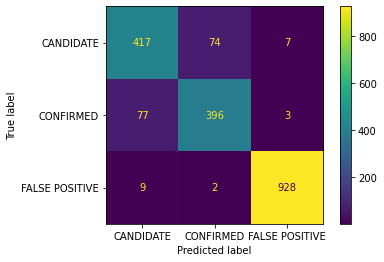

In [102]:
plot_confusion_matrix(
    model_forest,
    X_test, 
    y_test,
    values_format='.0f',
    display_labels=['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']
)

<AxesSubplot:>

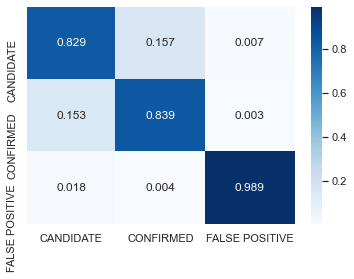

In [108]:
array = [[417,74,7],
         [77,396,3],
         [9,2,928]]

df_cm = pd.DataFrame(array, range(3), range(3))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1) # for label size

sns.heatmap(df_cm/np.sum(df_cm), annot=True,  fmt='.3f', cmap='Blues',
            xticklabels=['CANDIDATE','CONFIRMED','FALSE POSITIVE'],
            yticklabels=['CANDIDATE','CONFIRMED','FALSE POSITIVE']) 

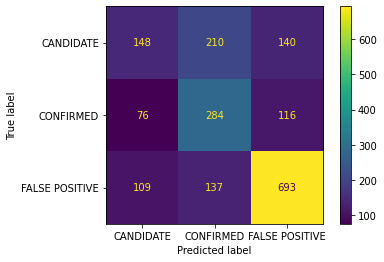

In [103]:
plot_confusion_matrix(
    model_linear,
    X_test, 
    y_test,
    values_format='.0f',
    display_labels=['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']
)

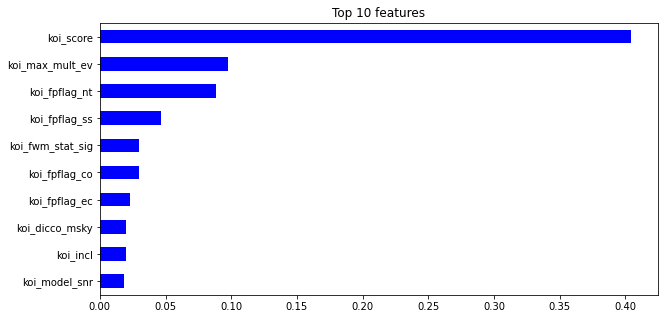

In [104]:
rf = model_forest.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

In [109]:
target2 = 'koi_disposition'
df2 = df.copy(deep=True)
df2.drop(columns='koi_score', inplace=True)
X2 = df2.drop(columns=target2)
y2 = df2[target]
print(X2.shape, y2.shape)

(9564, 177) (9564,)


In [111]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=0.8, random_state=42)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)
model_forest2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=750, random_state=42, n_jobs=-1, max_features=None)
)

# Time ~3 minutes
model_forest2.fit(X_train2, y_train2)
crossval_forest2 = cross_val_score(model_forest2, X_train2, y_train2, cv=5, n_jobs=-1)
print('CrossVal Random Forest Score:', crossval_forest2)
print('Mean:', crossval_forest2.mean())
print('Standard Deviation:', crossval_forest2.std())

(7651, 177) (1913, 177) (7651,) (1913,)
CrossVal Random Forest Score: [0.91770085 0.92026144 0.90457516 0.9254902  0.9       ]
Mean: 0.913605529300769
Standard Deviation: 0.00968479224451608


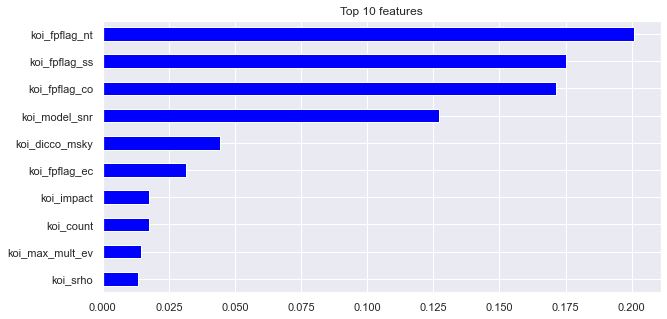

In [112]:
rf2 = model_forest2.named_steps['randomforestclassifier']
importances = pd.Series(rf2.feature_importances_, X_train2.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n2 = 10
plt.figure(figsize=(10,n2/2))
plt.title(f'Top {n2} features')
importances.sort_values()[-n2:].plot.barh(color='blue');